# Welcome to ECE 5460 Pytorch Tutorial!

OSU ECE 5460

In this tutorial, we will get familar with...

- basic usage of pytorch
- structure of training, validation, and testing
- checkpointing and telemetries

Written by Yuyi Chang (chang.1560@osu.edu) with inspirations and materials taken from [MIT 6.8300/6.8301](http://6.8300.csail.mit.edu/sp23/schedule.html), and official documentations.


> Before you start: make a copy of this file and saved to your account by `File - Save a copy in Drive`




## 1.1 Getting started with pytorch

1. A Python GPU-accelerated tensor library (NumPy, but faster)
2. Differentiable Programming with dynamic computation graphs
3. Flexible and efficient **neural network** library
4. Python-first framework (easy to integrate with other Python libraries, debug, and extend)
  + Quick conversion from & to NumPy array, integration with other Python libs.
  + Your favorite Python debugger.
  + Adding custom ops with Python/c++ extension.
  + Running in purely c++ environment with the c++ API.

Colab has pytorch preinstalled. You can load the torch package by `import torch`.

In [3]:
import torch
print(torch.__version__)

2.9.1


Literally any operation in `numpy` has its counterpart in `torch` - with a slight difference

In [4]:
import numpy as np

# zero array, same thing for ones, rand, and more!
a = np.zeros((2, 3))
print("=== numpy ===")
print(a)

b = torch.zeros(2, 3)
print("=== torch ===")
print(b)

# getting shape
print("\n=== getting shapes ===")
print("numpy", a.shape)
print("torch", b.size())

# you can convert numpy to tensor
c = torch.as_tensor(a) # or torch.Tensor(a)
print("\n === numpy to torch === ")
print(c)

# or tensor to numpy
print("\n === torch to numpy === ")
d = b.numpy()   # or np.array(b) or np.asarray(b)
print(d)

# casting types
aa = torch.zeros(2, 3)
print('=== casting types === ')
print(aa.dtype)
bb = aa.half()
print(bb.dtype)


=== numpy ===
[[0. 0. 0.]
 [0. 0. 0.]]
=== torch ===
tensor([[0., 0., 0.],
        [0., 0., 0.]])

=== getting shapes ===
numpy (2, 3)
torch torch.Size([2, 3])

 === numpy to torch === 
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

 === torch to numpy === 
[[0. 0. 0.]
 [0. 0. 0.]]
=== casting types === 
torch.float32
torch.float16


## 1.2 Using GPU

Important on colab, check if you are using GPU runtime for running any model

In [5]:
# check if there is CUDA device available
torch.cuda.is_available()

device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print("using device: {}".format(device))

using device: cpu


An array can be moved between devices

In [6]:
# define a new tensor
a = torch.randint(0, 10, (2, 3))
print(a)

b = a.to(device)
print(b)

c = b.cpu()
print(c)

tensor([[1, 0, 8],
        [6, 4, 0]])
tensor([[1, 0, 8],
        [6, 4, 0]])
tensor([[1, 0, 8],
        [6, 4, 0]])


Performing operations between two tensors not on the same device will result an error (very common when writing training code)

In [7]:
# this will result runtime error
aa = b + c

## 1.3 Gradient in PyTorch

What makes Pytorch to be very unique is the ability to calculate gradient, which is essential for any gradient-based optimization problems.
Pytorch uses [reverse-mode automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to compute gradients through any tensor operations.

More details at https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [8]:
# start with an array full of ones
a = torch.ones(2, 3, requires_grad=True)


In [9]:
# initially a has no gradient
print(a.grad)

None


In [10]:
# gradient will automatically flow during calculations
b = a.sum()
print(b)

# calculate gradient
b.backward()
print(a.grad)

tensor(6., grad_fn=<SumBackward0>)
tensor([[1., 1., 1.],
        [1., 1., 1.]])


What happens if you run `b = a.sum()` multiple times?

In [11]:
# just repeating...
# gradient will automatically flow during calculations
b = a.sum()
print(b)

# calculate gradient
b.backward()
print(a.grad)

tensor(6., grad_fn=<SumBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


What you observed is the gradient is being accumulated.
It can be cleared by running

In [12]:
a.grad.zero_()
print(a.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Why is the gradient all 1s?

When you compute `b = a.sum()` and then call `b.backward()`, the gradient stored in `a.grad` is all 1s. Here's why:

**Mathematical explanation:**
- If `a` is a tensor with elements `a[i,j]`, and `b = a.sum()` = `a[0,0] + a[0,1] + a[0,2] + a[1,0] + a[1,1] + a[1,2]`
- The gradient `∂b/∂a[i,j]` tells us: "How much does `b` change when `a[i,j]` changes by 1?"
- Since `b` is the sum of all elements, each element contributes equally: **∂b/∂a[i,j] = 1** for all `i,j`
- This means: increasing any element of `a` by 1 increases `b` by exactly 1

**Intuitive explanation:**
- Each element in `a` contributes equally to the sum
- There's no weighting or multiplication - it's just addition
- So the "sensitivity" of the sum to each element is the same: 1

This is different from other operations. For example, if we had `b = a.mean()`, the gradient would be `1/n` (where n is the number of elements), because each element contributes `1/n` to the mean.


In [13]:
# Demonstration: Compare gradients for different operations
a = torch.ones(2, 3, requires_grad=True)

# Operation 1: Sum (gradient = 1 for each element)
a.grad = None  # Clear previous gradients
b_sum = a.sum()
b_sum.backward()
print("Gradient after sum():")
print(a.grad)
print("Explanation: Each element contributes equally (1) to the sum\n")

# Operation 2: Mean (gradient = 1/n for each element)
a.grad = None
b_mean = a.mean()
b_mean.backward()
print("Gradient after mean():")
print(a.grad)
print(f"Explanation: Each element contributes 1/{a.numel()} = {1/a.numel():.4f} to the mean\n")

# Operation 3: Weighted sum (gradient = weight for each element)
a.grad = None
weights = torch.tensor([[2.0, 3.0, 4.0], [5.0, 6.0, 7.0]])
b_weighted = (a * weights).sum()
b_weighted.backward()
print("Gradient after weighted sum (a * weights).sum():")
print(a.grad)
print("Explanation: Each element's gradient equals its weight")


Gradient after sum():
tensor([[1., 1., 1.],
        [1., 1., 1.]])
Explanation: Each element contributes equally (1) to the sum

Gradient after mean():
tensor([[0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667]])
Explanation: Each element contributes 1/6 = 0.1667 to the mean

Gradient after weighted sum (a * weights).sum():
tensor([[2., 3., 4.],
        [5., 6., 7.]])
Explanation: Each element's gradient equals its weight


## 2. Building a model in PyTorch

Pytorch provides a large collection of building blocks to build a model in any sizes.

- affine layers
- activation functions
- normalization layers
- [Initialization schemes](https://pytorch.org/docs/stable/nn.html#torch-nn-init)
- [Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Embeddings](https://pytorch.org/docs/stable/nn.html#sparse-layers)
- [Distributed and Multi-GPU training](https://pytorch.org/docs/stable/nn.html#dataparallel-layers-multi-gpu-distributed)
- [Gradient-based optimizers](https://pytorch.org/docs/stable/optim.html)
- [Learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- etc.

## 2.1 Linear regression with `nn.Linear()`

Suppose we want to solve a linear regression problem

$$y = \beta_0 + \beta_1 * x$$

Let's start by generating some data

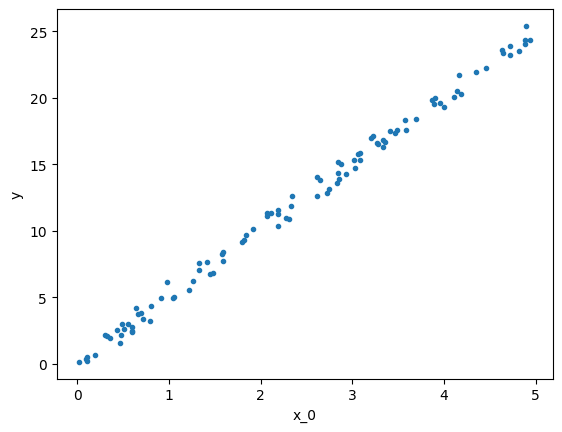

In [14]:
import matplotlib.pyplot as plt

num_sample = 100
num_feature = 1

secret_pin = 0 # the actual pin will be given in the lecture

np.random.seed(secret_pin)
X = 5 * np.random.rand(num_sample, num_feature)
beta = np.array([5])
y = np.dot(X, beta) + np.random.randn(100) * 0.5

plt.plot(X[:,0], y, '.')
plt.xlabel('x_0')
plt.ylabel('y')

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

In [15]:
import torch.nn as nn

# Define a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Create the model
input_size = 1  # 10 input features
output_size = 1  # 1 output (predicted value)
model = LinearRegressionModel(input_size, output_size)

In [16]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

Putting everything together

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Define a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Create the model
input_size = 1  # 10 input features
output_size = 1  # 1 output (predicted value)
model = LinearRegressionModel(input_size, output_size)

model = model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print loss every 500 steps
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the final model parameters
final_parameters = model.state_dict()
print("Final model parameters:")
for param_name, param_value in final_parameters.items():
  print(param_name, param_value)


Epoch [500/5000], Loss: 3.7694
Epoch [1000/5000], Loss: 1.2699
Epoch [1500/5000], Loss: 0.4090
Epoch [2000/5000], Loss: 0.2604
Epoch [2500/5000], Loss: 0.2485
Epoch [3000/5000], Loss: 0.2481
Epoch [3500/5000], Loss: 0.2481
Epoch [4000/5000], Loss: 0.2481
Epoch [4500/5000], Loss: 0.2481
Epoch [5000/5000], Loss: 0.2481
Final model parameters:
linear.weight tensor([[4.9937]])
linear.bias tensor([0.1111])


We can run evaluation on a new data point

In [18]:
X_test = torch.Tensor([1]).to(device)
with torch.no_grad():
  print(model(X_test))


tensor([5.1048])


## 3. A more complex model

credit: MIT 6.830


In [19]:
# getting MNIST data
import torchvision
mnist_train = torchvision.datasets.MNIST(root='./data', download=True, train=True)

In [20]:
image, label = mnist_train[5]
print('This is a digit {}:'.format(label))
image

print(type(image))

This is a digit 2:
<class 'PIL.Image.Image'>


In [21]:
# define data preprocessing
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),  # [0, 1] range => [-1, 1] range
])

mnist_train = torchvision.datasets.MNIST(root='./data', download=True, train=True,
                                         transform=transform)
mnist_val = torchvision.datasets.MNIST(root='./data', download=True, train=False,
                                         transform=transform)

print('training set size:\t{}'.format(len(mnist_train)))
print('validation set size:\t{}'.format(len(mnist_val)))

training set size:	60000
validation set size:	10000


In [22]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,                   # shuffle training set
                                           num_workers=2,                  # turns on multi-processing loading so training is not blocked by data loading
                                           pin_memory=True)                # pin_memory allows faster transfer from CPU to GPU
val_loader = torch.utils.data.DataLoader(mnist_val,
                                         batch_size=batch_size,
                                         num_workers=2,
                                         pin_memory=True)

some testing...

In [23]:
# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.

images, labels = next(iter(train_loader))
print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))

/Users/wenqifan/Desktop/image processing/tutorial_2/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


batched image tensor shape: torch.Size([512, 1, 28, 28])
batched label tensor shape: torch.Size([512])


In [24]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

We will use a convolutional network for classification. The following architecture is adapted from the famous [LeNet-5](https://ieeexplore.ieee.org/document/726791) [1].

[1] LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.

some testing...

In [25]:
model = MyNet().to(device)
random_input = torch.randn(8, 1, 28, 28, device=device)
output = model(random_input)
print(output.shape)

torch.Size([8, 10])


## In-class activity: finish training/validation loop



### Initialize model, loss function, and optimizer


In [26]:
model = MyNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



### Training parameters


In [27]:
num_epochs = 10



### Training and validation loop


In [28]:
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
    
    # Print statistics
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

Epoch [1/10]
Train Loss: 0.7280, Train Acc: 81.63%
Val Loss: 0.1950, Val Acc: 94.48%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.1570, Train Acc: 95.28%
Val Loss: 0.1207, Val Acc: 96.30%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.1021, Train Acc: 96.91%
Val Loss: 0.0896, Val Acc: 97.25%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0783, Train Acc: 97.56%
Val Loss: 0.0668, Val Acc: 97.92%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0646, Train Acc: 98.00%
Val Loss: 0.0537, Val Acc: 98.33%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0531, Train Acc: 98.33%
Val Loss: 0.0474, Val Acc: 98.47%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0478, Train Acc: 98.54%
Val Loss: 0.0420, Val Acc: 98.72%
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.0419, Train Acc: 98.6

In [29]:

model_path = 'mnist_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')



Model saved to mnist_model.pth


In [30]:

loaded_model = MyNet().to(device)

# Load the state_dict
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Set to evaluation mode

print('Model loaded successfully!')
print(f'Model is on device: {next(loaded_model.parameters()).device}')

# Verify the model works by testing on a sample
with torch.no_grad():
    sample_image, sample_label = next(iter(val_loader))
    sample_image = sample_image[0:1].to(device)  # Take first image
    sample_label = sample_label[0:1].to(device)
    
    output = loaded_model(sample_image)
    _, predicted = torch.max(output, 1)
    
    print(f'\nTest prediction:')
    print(f'  True label: {sample_label.item()}')
    print(f'  Predicted: {predicted.item()}')
    print(f'  Correct: {predicted.item() == sample_label.item()}')


Model loaded successfully!
Model is on device: cpu

Test prediction:
  True label: 7
  Predicted: 7
  Correct: True
